## VERY GENEROUS ADVICE FROM THE TPU-PODCAST DISCORD:

- pbaylies: Use features of an image model
- pbaylies: Remember to align your target image
- pbaylies worked on an encoder one might use: https://github.com/pbaylies/stylegan-encoder
- pbaylies: MSE on VGG features _should_ work
- mefaso: StyleGAN2-ADA implementation comes with a "projector": https://github.com/NVlabs/stylegan2-ada/blob/main/projector.py


In [ ]:
# TODO:
# Clean up stuff we made in find_louis2 and then use MSELoss on vggface features!

# Define graph:
# z = Variable()
# loss = MSELoss(VGGFace(target), VGGFace(Generator(z)))
# Then over many rounds, optimize "loss" by changing "z"

In [52]:
from PIL import Image
import matplotlib.pyplot as plt
import os
import pickle
import numpy as np
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib
import config
import tensorflow as tf
from keras_vggface.vggface import VGGFace
import numpy as np
import tensorflow_probability as tfp
from tqdm import trange
from matplotlib.pyplot import imshow

In [115]:
def get_target_values():
    target_files = [
        'targets/louis_target_white.png',
        'targets/louis_target_2.png',
        'targets/louis_target_3.png',
    ]
    targets = []
    for target_file in target_files:
        # LOAD my portrait
        %matplotlib inline

        f = open(target_file, 'rb')
        im = Image.open(f)

        target = (np.array(im)[:, :, :3].astype(float) / 255)
        #target = np.expand_dims(target, 0)
        target = np.transpose(target, [2, 0, 1])
        targets.append(target)
        
    return np.stack(targets)

target_value = get_target_values()
print(target_value.shape)

(3, 3, 1024, 1024)


Tensor("add:0", shape=(3,), dtype=float32)


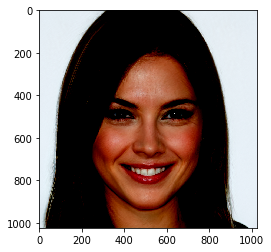

In [119]:
def kl_divergence(z):
    # for z, how much less likely is it that it came from mu = 0 and var = 1 than the current mu and var?
    p = tfp.distributions.Normal(tf.zeros_like(z), tf.ones_like(z))
    log_prob_pz = p.log_prob(z)
    kl = -log_prob_pz
    kl = tf.math.reduce_mean(kl, -1)
    
    return kl

tf.reset_default_graph()
sess = tf.get_default_session()
if(sess):
    sess.close()

with tf.InteractiveSession().as_default() as sess:
    # Load our two pre-trained models 🙏
    f = open('karras2019stylegan-celebahq-1024x1024.pkl', 'rb')
    _G, _D, Gs = pickle.load(f)
    vggface = VGGFace(model='vgg16', include_top=False) 
    
    # Let's define the graph for the loss
    target = tf.placeholder(float, (3, 3, 1024, 1024), name="target_placeholder")
    z = tf.Variable(
        np.random.normal(loc=0.0, scale=1.0, size=(1, 512)).astype(np.float32)
    )
    sess.run(z.initializer)
    
    vgg_target = tf.reshape(
        tensor=vggface(
            tf.image.resize(tf.transpose(target, perm=[0, 2, 3, 1]), size=[244, 244])
        ),
        shape=(-1, 7 * 7 * 512)
    )
    prediction = tf.tile(
        Gs.get_output_for(
            z,
            None
        ),
        [3, 1, 1, 1]
    )
    vgg_prediction = tf.reshape(
        tensor=vggface(
            tf.image.resize(tf.transpose(prediction, perm=[0, 2, 3, 1]), size=[244, 244])
        ),
        shape=(-1, 7 * 7 * 512)
    )

    reconstruction_loss = tf.keras.losses.MSE(vgg_prediction, vgg_target) * 1000
    kl_divergence_loss = kl_divergence(z)
    loss = reconstruction_loss + kl_divergence_loss

    imshow(np.transpose(sess.run(prediction), [0, 2, 3, 1])[0])

In [130]:
with tf.device('device:GPU:0'):
    sess = tf.get_default_session()

    #optimizer = tf.train.GradientDescentOptimizer(
    #    learning_rate=(0.06), use_locking=False, name='GradientDescent'
    #)
    optimizer = tf.train.AdamOptimizer(
        learning_rate=(0.006)  
    )
    minimize_fn = optimizer.minimize(
        loss, 
        var_list=[z],
    )
    sess.run([var.initializer for var in optimizer.variables()])

    t = trange(1000)
    for i in t:       
        [reconstruction_loss_result, kl_divergence_loss_result, loss_result, minimize_result] = sess.run([reconstruction_loss, kl_divergence_loss, loss, minimize_fn], feed_dict={
            "target_placeholder:0": target_value
        })

        t.set_description(str(reconstruction_loss_result) + ' + ' + str(kl_divergence_loss_result) + ' = ' + str(loss_result))

[3.0894566 1.9134945 2.909599 ] + [1.0993168] = [4.188773  3.0128112 4.008916 ]:  18%|█▊        | 182/1000 [01:54<08:36,  1.58it/s]


KeyboardInterrupt: 

In [134]:
with open('z.pickle', 'wb') as handle:
    pickle.dump(sess.run(z), handle)
    


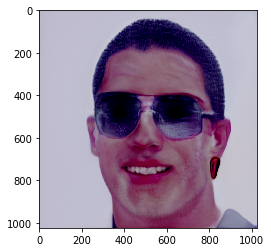

In [135]:
imshow(np.transpose(sess.run(prediction), [0, 2, 3, 1])[0])

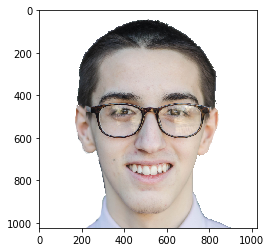

In [105]:
imshow(np.transpose(target_value, [0, 2, 3, 1])[0])